# Considerações:
- Exemplo usando LangChain utilizando Sequential Chain

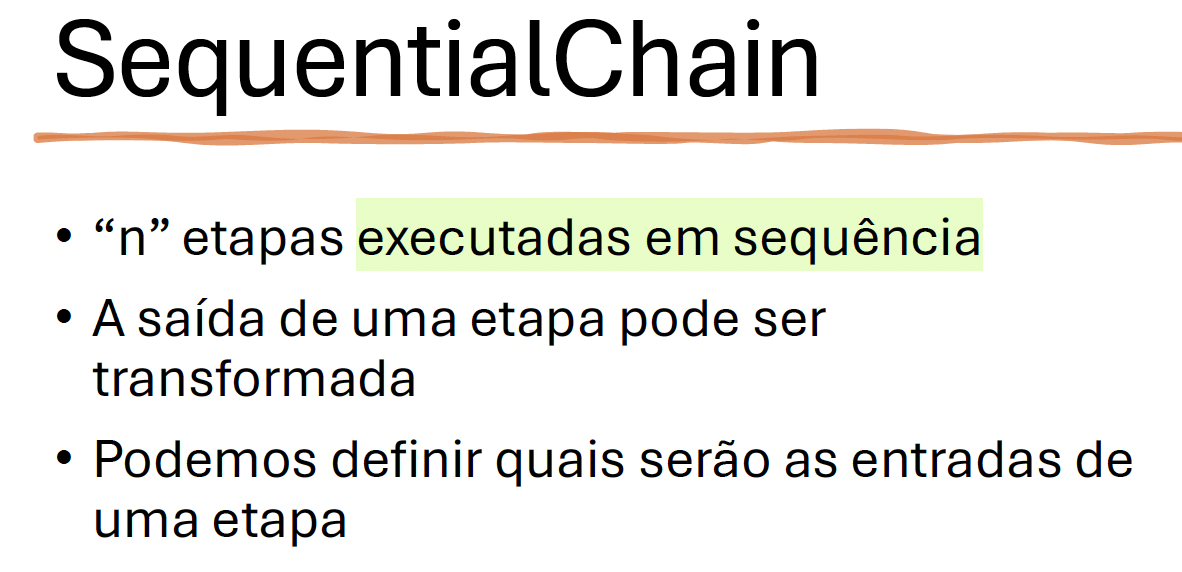

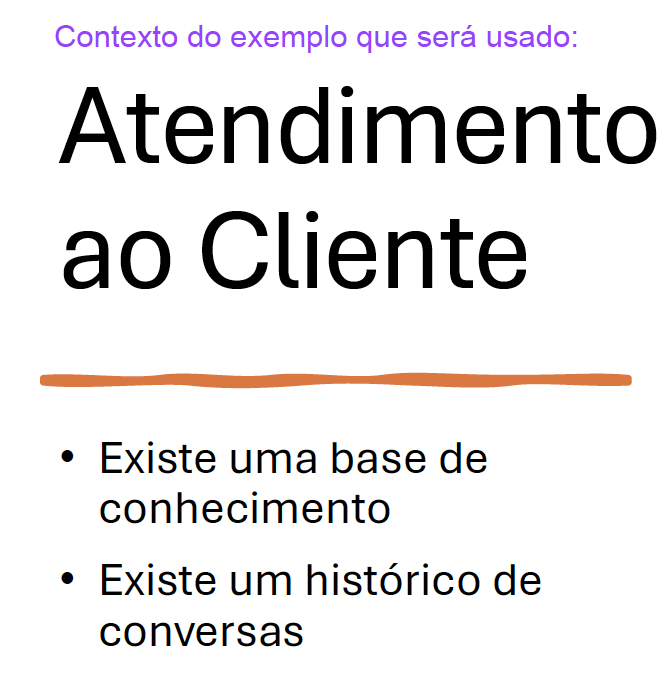

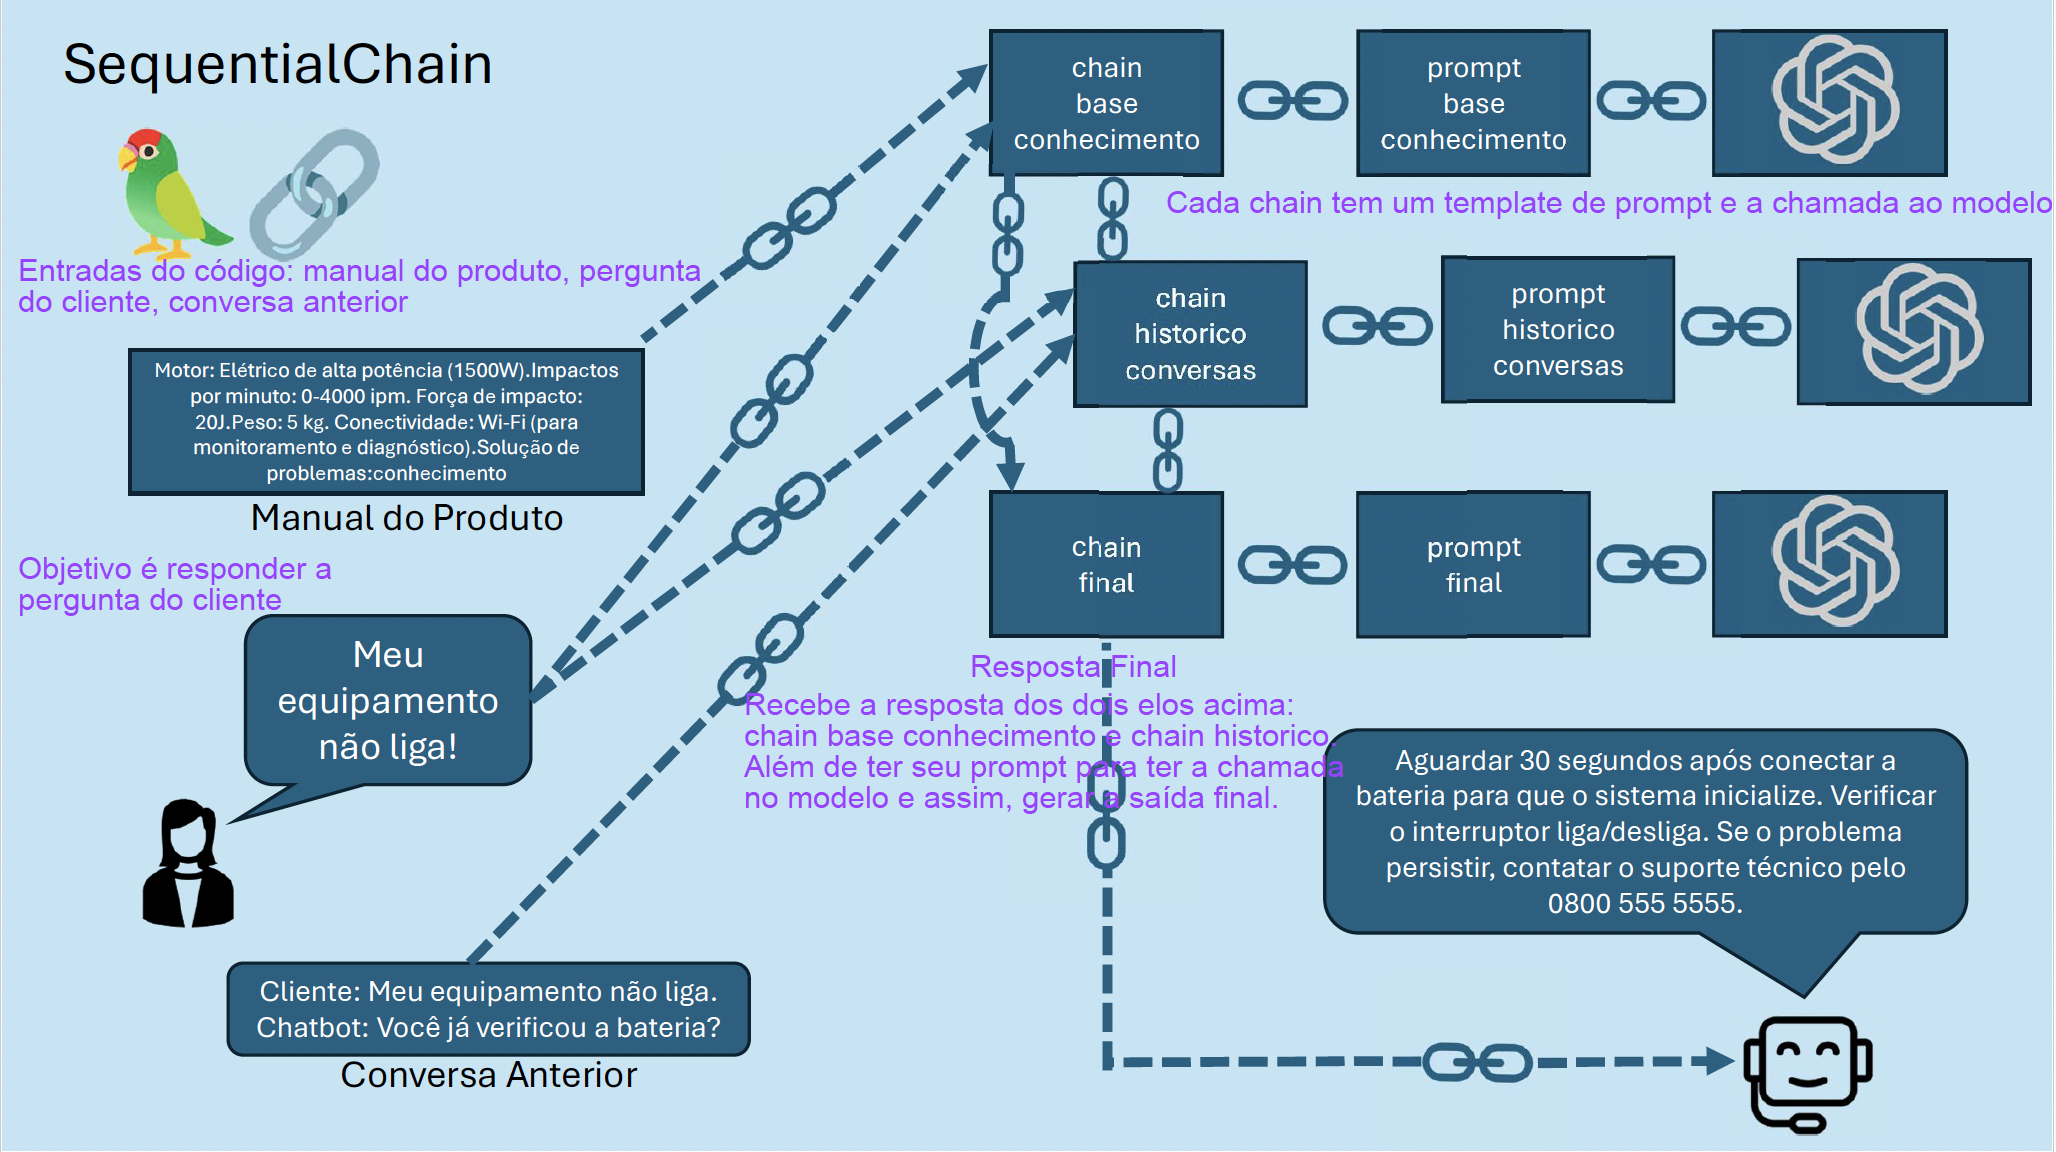

# Setup

In [2]:
# importando as bibliotecas

from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.document_loaders import TextLoader
import yaml
import os

In [3]:
# lendo o arquivo config.yaml para ter acesso a chave de acesso da OpenAI

with open('config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)
os.environ['OPENAI_API_KEY'] = config['OPENAI_API_KEY']

In [4]:
openai = ChatOpenAI(model_name='gpt-4o', temperature=0) # instanciando um objeto OpenAI

# SequentialChain

In [5]:
# Carregando informações externas
# Carregando o documento: chain base conhecimento (print SequentialChain)
loader = TextLoader('base_conhecimento_britadeira.txt')
documents = loader.load()

# Carregando histórico de conversas: chain historico conversas (print SequentialChain)
historico_conversas = """Cliente: Minha britadeira não liga. Chatbot: Você já verificou 
                         se a bateria está carregada e conectada corretamente?""" # como já teve a indicação de verificar bateria, espera-se que o modelo de outra resposta conforme o documento de base de conhecimento

# Pergunta do cliente: chain final (print SequentialChain)
pergunta = "Minha britadeira não liga. Eu já veriquei e a bateria está carregada e conectada corretamente"

## Definições sobre o equipamento não ligar existentes na base de conhecimento
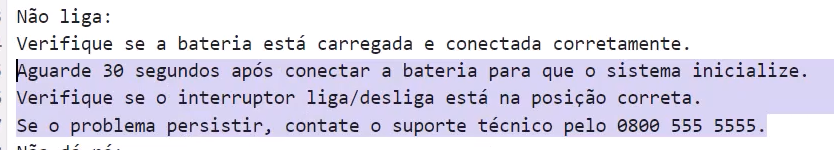

In [6]:
# Construindo um dicionário com os dados da base de conhecimento, a pergunta do usuário e o histórico de conversa
# depois será passado para o template.

inputs = {
    "context": "\n".join(doc.page_content for doc in documents),
    "question": pergunta,
    "historico": historico_conversas
}

In [7]:
print(inputs) # imprimindo o input

{'context': 'Base de Conhecimento Aprimorada para a Britadeira XP500\nBritadeira XP500\n\nEspecificações:\n\nMotor: Elétrico de alta potência (1500W).\nImpactos por minuto: 0-4000 ipm.\nForça de impacto: 20J.\nPeso: 5 kg.\nConectividade: Wi-Fi (para monitoramento e diagnóstico).\nSolução de problemas:\n\nNão liga:\nVerifique se a bateria está carregada e conectada corretamente.\nAguarde 30 segundos após conectar a bateria para que o sistema inicialize.\nVerifique se o interruptor liga/desliga está na posição correta.\nSe o problema persistir, contate o suporte técnico pelo 0800 555 5555.\nNão dá ré:\nVerifique se a alavanca de ré está engatada.\nVerifique se há alguma obstrução impedindo o movimento da broca.\nSe o problema persistir, desligue a britadeira e contate o suporte técnico.\nWi-Fi não conecta:\nVerifique se o Wi-Fi da britadeira está ligado.\nVerifique se você está inserindo a senha correta da rede Wi-Fi.\nReinicie a britadeira e tente conectar novamente.\nSe o problema pers

In [8]:
# Preparação dos templates para cada chain
# context: armazena a base de conhecimento
# question: armazena a pergunta do usuário
# historico: armazena o historico de conversa

prompt_base_conhecimento = PromptTemplate(
    input_variables=["context", "question"],
    template="""Use o seguinte contexto para responder à pergunta. 
    Responda apenas com base nas informações fornecidas.
    Não forneceça instruções de procedimento já realizados.
    Não utilize informações externas ao contexto:
    Contexto: {context}
    Pergunta: {question}"""
)

prompt_historico_conversas = PromptTemplate(
    input_variables=["historico", "question"],
    template="""Use o histórico de conversas para responder à pergunta. 
    Responda apenas com base nas informações fornecidas. 
    Não forneceça instruções de procedimento já realizados.
    Não utilize informações externas ao contexto:
    Histórico: {historico}
    Pergunta: {question}"""
)

prompt_final = PromptTemplate(
    input_variables=["resposta_base_conhecimento", "resposta_historico_conversas"],
    template="""Combine as seguintes respostas para gerar uma resposta final,
    mas não forneça instruções de procedimentos já realizados:
    Resposta da base de conhecimento: {resposta_base_conhecimento}
    Resposta do histórico de conversas: {resposta_historico_conversas}"""
)

In [9]:
print(prompt_base_conhecimento) # imprimindo o prompt da base de conhecimento

input_variables=['context', 'question'] template='Use o seguinte contexto para responder à pergunta. \n    Responda apenas com base nas informações fornecidas.\n    Não forneceça instruções de procedimento já realizados.\n    Não utilize informações externas ao contexto:\n    Contexto: {context}\n    Pergunta: {question}'


In [10]:
# Definição da sequência dos chains  

chain_base_conhecimento = prompt_base_conhecimento | openai # o pipe | que concatena os processos/chain
chain_historico_conversas = prompt_historico_conversas | openai
chain_final = prompt_final | openai

In [11]:
print(chain_base_conhecimento) # imprimindo a sequencia de chain da base de conhecimento

first=PromptTemplate(input_variables=['context', 'question'], template='Use o seguinte contexto para responder à pergunta. \n    Responda apenas com base nas informações fornecidas.\n    Não forneceça instruções de procedimento já realizados.\n    Não utilize informações externas ao contexto:\n    Contexto: {context}\n    Pergunta: {question}') last=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x112edcb30>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x112edddf0>, model_name='gpt-4o', temperature=0.0, openai_api_key=SecretStr('**********'), openai_proxy='')


In [12]:
print(chain_historico_conversas) # imprimindo a sequencia de chain do histórico

first=PromptTemplate(input_variables=['historico', 'question'], template='Use o histórico de conversas para responder à pergunta. \n    Responda apenas com base nas informações fornecidas. \n    Não forneceça instruções de procedimento já realizados.\n    Não utilize informações externas ao contexto:\n    Histórico: {historico}\n    Pergunta: {question}') last=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x112edcb30>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x112edddf0>, model_name='gpt-4o', temperature=0.0, openai_api_key=SecretStr('**********'), openai_proxy='')


In [13]:
# Passando dados e executando o chamado para o modelo
# context: armazena a base de conhecimento
# question: armazena a pergunta do usuário
# historico: armazena o historico de conversa

resultado_base_conhecimento = chain_base_conhecimento.invoke({"context": inputs["context"], "question": inputs["question"]})

resultado_historico_conversas = chain_historico_conversas.invoke({"historico": inputs["historico"], "question": inputs["question"]})

# no resultado final uso do resultados do processamento da base de conhecimento e historico de conversar
resultado_final = chain_final.invoke({"resposta_base_conhecimento": resultado_base_conhecimento, 
                                      "resposta_historico_conversas": resultado_historico_conversas})

In [14]:
# imprimindo os resultados intermediários: base de conhecimento e histórico de conversa

print("Resultado Base de Conhecimento:\n", resultado_base_conhecimento)
print("----")
print("Resultado Histórico de Conversas:\n", resultado_historico_conversas)

Resultado Base de Conhecimento:
 content='Aguarde 30 segundos após conectar a bateria para que o sistema inicialize. Verifique se o interruptor liga/desliga está na posição correta. Se o problema persistir, contate o suporte técnico pelo 0800 555 5555.' response_metadata={'token_usage': {'completion_tokens': 52, 'prompt_tokens': 681, 'total_tokens': 733, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a79d8dac1f', 'finish_reason': 'stop', 'logprobs': None} id='run-26d7e0bc-7bbd-4ef0-a612-381c8bcd1a06-0' usage_metadata={'input_tokens': 681, 'output_tokens': 52, 'total_tokens': 733}
----
Resultado Histórico de Conversas:
 content='Você já verificou se há algum problema com o interruptor ou se há algum dano visível nos cabos?' response_metadata={'token_usage': {'completion_

In [15]:
# imprimindo o resultado final

print(resultado_final.content)

Aguarde 30 segundos após conectar a bateria para que o sistema inicialize. Verifique se o interruptor liga/desliga está na posição correta e se há algum problema com o interruptor ou dano visível nos cabos. Se o problema persistir, contate o suporte técnico pelo 0800 555 5555.


In [16]:
# imprimindo o resultado final completo

print(resultado_final)

content='Aguarde 30 segundos após conectar a bateria para que o sistema inicialize. Verifique se o interruptor liga/desliga está na posição correta e se há algum problema com o interruptor ou dano visível nos cabos. Se o problema persistir, contate o suporte técnico pelo 0800 555 5555.' response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 492, 'total_tokens': 560, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_9faba9f038', 'finish_reason': 'stop', 'logprobs': None} id='run-6f02321e-231f-4c54-900a-6d866bf8bc54-0' usage_metadata={'input_tokens': 492, 'output_tokens': 68, 'total_tokens': 560}
